Our first approach is to generate, by hand, a simple collections of sentences organised by intents and associated answers.
We will then process that data to make it suitable for NLP applications, encode it using "bag of word" and train a neural network to predict user intent from an utterance.

Then, we wil used pre-trained word embeddings

Then, we will generate training data using OpenAI GPT-3 API and train it, using both bag of words and word embeddings
We can also try TF-IDF to compare it with the NN.

A chatbot needs to understand intents in users' utterances. For this purpose, we train a classifier.

I use the IMDB review dataset for basic testing

# Import / Generate data

In this section, we import our dataset, made of hand-crafted sentences and the corresponding intent.

In [1]:
import json

import numpy as np
import pandas as pd
from sklearn import tree, svm, naive_bayes
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from time import time
from collections import defaultdict
import spacy
from spacy.tokens import DocBin
nlp = spacy.load("en_core_web_lg")

In [18]:
data_file = open('intents.json').read()
intents = json.loads(data_file)


data = []
for intent in intents['intents']:
    for pattern in intent['patterns']:
        data.append([pattern, intent['tag']])

df_json = pd.DataFrame(data, columns=['text','intent'])

In [19]:
df_csv = pd.read_csv("sentences/full.csv")

In [20]:
df = pd.concat([df_json, df_csv], axis=0)
df

,text,intent
0,Hi,greeting
1,Hey,greeting
2,Is anyone there ?,greeting
3,Hello,greeting
4,Good morning !,greeting
...,...,...
240,Thank you for your care.,gratitude
241,Thank you for being my friend.,gratitude
242,Thank you for everything.,gratitude
243,You are the best!,gratitude


In [105]:
print(df['text'].apply(lambda x: len(x.split(' '))).sum())

1530


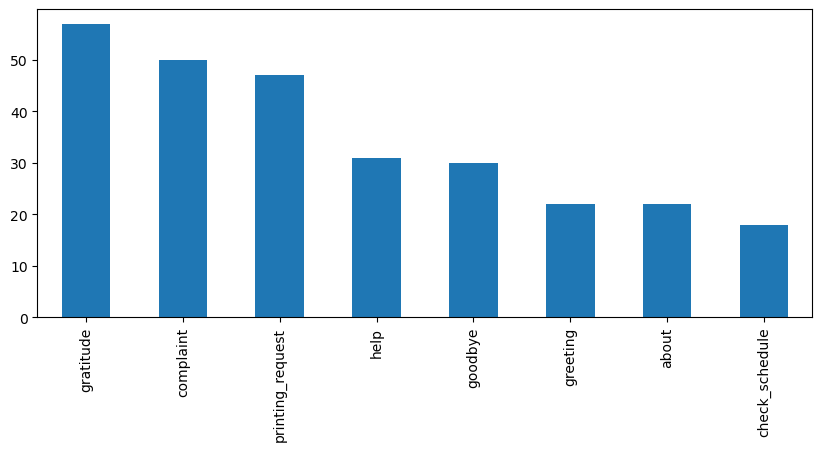

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
df.intent.value_counts().plot(kind='bar');

The intents that we want the chatbot to recognize are :

In [21]:
df["intent"].unique()

array(['greeting', 'goodbye', 'gratitude', 'about', 'help',
       'printing_request', 'complaint', 'check_schedule'], dtype=object)

# Data pre-processing

In this section, we define functions to preprocess our text (parse it using a SpaCy pipeline) and to process it (extract tokens, lemmas or embeddings depending on the application).
We save the preprocessed data to disk to avoid repeating this computationally expensive task.

In [ ]:
# fine-tune preprocessing for spaCy word embeddings using this method : https://www.kaggle.com/code/christofhenkel/how-to-preprocessing-when-using-embeddings

In [22]:
# Helper functions

def lemmatize_text(text, preprocessed=True):
    return process_text(text, "lemmatize", preprocessed)

def tokenize_text(text, preprocessed=True):
    return process_text(text, "tokenize", preprocessed)

def process_text(text, mode: str, preprocessed=True):
    if not preprocessed:
        text = nlp(text)
    if mode == "tokenize":
        processed_text = [token.text for token in text] # token and embed must have the same processing + SpaCy provides embeddings for punctuation
    elif mode == "embed":
        processed_text = [token.vector for token in text] # token and embed must have the same processing
    elif mode == "lemmatize":
        processed_text = [token.lemma_ for token in text
                               if not token.is_punct and not token.is_space and not token.like_url and not token.like_email]
    else:
        raise ValueError("Mode not supported")
    return processed_text

def save_preprocessed(raw_text, save_path):
    doc_bin = DocBin(attrs=["LEMMA", "ENT_IOB", "ENT_TYPE"], store_user_data=True)
    for doc in nlp.pipe(raw_text):
        doc_bin.add(doc)
    # save DocBin to a file on disc
    doc_bin.to_disk(save_path)

In [23]:
file_name_spacy = 'preprocessed_dataset_chatbot.spacy'
save_preprocessed(raw_text=df["text"], save_path=file_name_spacy)

# Load DocBin at later time or on different system from disc or bytes object
doc_bin = DocBin().from_disk(file_name_spacy)
df["doc"] = list(doc_bin.get_docs(nlp.vocab))

In [26]:
df

,text,intent,doc
0,Hi,greeting,(Hi)
1,Hey,greeting,(Hey)
2,Is anyone there ?,greeting,"(Is, anyone, there, ?)"
3,Hello,greeting,(Hello)
4,Good morning !,greeting,"(Good, morning, !)"
...,...,...,...
240,Thank you for your care.,gratitude,"(Thank, you, for, your, care, .)"
241,Thank you for being my friend.,gratitude,"(Thank, you, for, being, my, friend, .)"
242,Thank you for everything.,gratitude,"(Thank, you, for, everything, .)"
243,You are the best!,gratitude,"(You, are, the, best, !)"


# Data preparation

In this section, we create different training datasets, processing them using SpaCy and our helper functions :

- `X_train` is a pandas Series made of all preprocessed sentence
- `X_train_embedded` pandas Series, each sentence is a list of embeddings
- `X_train_embedded_avg` panda Series, each sentence is the average of each of its words' embedding (using the sum would give embeddings of different magnitude depending of the sentence's length)
- `X_train_embedded_avg_tfidf` The previous average is weighted using TF-IDF coefficient (trained on ngrams of 1 token)

In [71]:
train, test = train_test_split(df, test_size=0.3)

X_train = train["doc"].reset_index(drop=True)
y_train = train["intent"].reset_index(drop=True)

X_test = test["doc"].reset_index(drop=True)
y_test = test["intent"].reset_index(drop=True)

X_train_embedded = train["doc"].apply(process_text, args=("embed", True,))
X_train_embedded_avg = X_train_embedded.apply(np.mean, axis=0).apply(pd.Series)

X_test_embedded = test["doc"].apply(process_text, args=("embed", True,))
X_test_embedded_avg = X_test_embedded.apply(np.mean, axis=0).apply(pd.Series)

In [ ]:
# The following code block construct a sentence representation as the average of all embeddings of the words in it, weighted by their tfidf score
# This is not practical in our chatbot : using word embeddings is one way of mitigating the small dataset size, as words close in meaning should have similar embeddings
# Weighing by tf-idf score would "delete" unknown world from the vocabulary, which we do not want

vectorizer = TfidfVectorizer(ngram_range=(1, 1), lowercase=False, tokenizer=tokenize_text, max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train) # Maybe not ? Bias, vocab for test in vect // But that would be dumb to not use the vocab for the final one // BEST : Only do vocab on X_train, but if tfidf selected train final on FULL dataset
weighted_averages = []
for (idxRow, sentence) in X_train.items():
    sum_embeddings = 0
    for idxWord, word in enumerate(sentence):
        try:
            tfidf_idx = vectorizer.vocabulary_[word]
        except(KeyError):
            continue
        sum_embeddings += (X_train_tfidf.toarray())[idxRow][tfidf_idx] * X_train_embedded.iloc[idxRow][idxWord]
    weighted_averages.append(sum_embeddings/len(sentence))

X_train_embedded_avg_tfidf = pd.Series(weighted_averages).apply(pd.Series)

X_test_tfidf = vectorizer.transform(X_test)
weighted_averages = []
for (idxRow, sentence) in X_test.items():
    sum_embeddings = 0
    for idxWord, word in enumerate(sentence):
        try:
            tfidf_idx = vectorizer.vocabulary_[word]
        except(KeyError):
            continue
        sum_embeddings += (X_test_tfidf.toarray())[idxRow][tfidf_idx] * X_test_embedded.iloc[idxRow][idxWord]
    weighted_averages.append(sum_embeddings/len(sentence))

X_test_embedded_avg_tfidf = pd.Series(weighted_averages).apply(pd.Series)

TODO : Explain alternatives (sense2vec, Doc2vec)

# Classic ML

Our first approach to create our classifier is to use traditional ML algorithms.

We will use several algorithms and 3 different approach to represent our training data :

- A classic TF-IDF representation (with or without IDF, which is equivalent to a bag-of-words approach)
- A "sentence2vec" (or s2v) approach, where a sentence is the average of its words' embedding.
- A TF-IDF weighted average of word embeddings, s2v_tfidf

## Models preparation

We use the sklearn implementation of GridSearchCV, which optimises the parameters of an estimator (here, our classifiers) by cross-validated grid-search over a parameter grid.
We select different algorithms, define a pipeline and a set of parameters for each of those.
The use of the pipeline allows us to select the best parameters for the TF-IDF vectorization.

The size of our dataset does not contrains us in the choice of the algorithm, as training time is not a concern (No need to swap SVC for LinearSVC or SGDClassifier, for example)

GridSearchCV uses K-fold as the cross-validation method. Here, we used 5-fold stratified K-fold.

List parameters for clf and vectorizer ?

Below are defined the models and their corresponding hyperparameters to tune for the TF-IDF approach

In [29]:
vect = TfidfVectorizer(lowercase=False, tokenizer=lemmatize_text, max_features=3000)

gs_dict_tfidf = defaultdict(dict)

dectree = tree.DecisionTreeClassifier() # CART
svm_clf = svm.SVC()
multi_nb = naive_bayes.MultinomialNB() # Not suitable for negative values (thus not suitable for word embeddings)
log_reg = LogisticRegression()
random_forest = RandomForestClassifier()
skboost = GradientBoostingClassifier()

gs_dict_tfidf['dectree']['pipeline'] = Pipeline([
    ('vect', vect),
    ('dectree', dectree)])
gs_dict_tfidf['svm_clf']['pipeline'] = Pipeline([
    ('vect', vect),
    ('svm_clf', svm_clf)])
gs_dict_tfidf['multi_nb']['pipeline'] = Pipeline([
    ('vect', vect),
    ('multi_nb', multi_nb)])
gs_dict_tfidf['log_reg']['pipeline'] = Pipeline([
    ('vect', vect),
    ('log_reg', log_reg)])
gs_dict_tfidf['random_forest']['pipeline'] = Pipeline([
    ('vect', vect),
    ('random_forest', random_forest)])
gs_dict_tfidf['skboost']['pipeline'] = Pipeline([
    ('vect', vect),
    ('skboost', skboost)])

gs_dict_tfidf['dectree']['params'] = {
    "dectree__max_depth": [4, 40],
    "vect__ngram_range": ((1, 1), (1, 2), (1,3), (1,4)),
    "vect__use_idf": (True, False),
    "vect__binary": (True, False),
}
gs_dict_tfidf['svm_clf']['params'] = {
    "svm_clf__kernel": ["linear", "rbf"],
    "vect__ngram_range": ((1, 1), (1, 2), (1,3), (1,4)),
    "vect__use_idf": (True, False),
    "vect__binary": (True, False),
}
gs_dict_tfidf['multi_nb']['params'] = {
    "multi_nb__alpha": [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],
    "vect__ngram_range": ((1, 1), (1, 2), (1,3), (1,4)),
    "vect__use_idf": (True, False),
    "vect__binary": (True, False),
}
gs_dict_tfidf['log_reg']['params'] = {
    "vect__ngram_range": ((1, 1), (1, 2), (1,3), (1,4)),
    "vect__use_idf": (True, False),
    "vect__binary": (True, False),
}
gs_dict_tfidf['random_forest']['params'] = {
    "vect__ngram_range": ((1, 1), (1, 2), (1,3), (1,4)),
    "vect__use_idf": (True, False),
    "vect__binary": (True, False),
}
gs_dict_tfidf['skboost']['params'] = {
    "vect__ngram_range": ((1, 1), (1, 2), (1,3), (1,4)),
    "vect__use_idf": (True, False),
    "vect__binary": (True, False),
}

Below are defined the models to be used with the two embeddings approaches

In [30]:
gs_dict_embeddings = defaultdict(dict)
# classifiers to use
dectree = tree.DecisionTreeClassifier()
svm_clf = svm.SVC()

gs_dict_embeddings['dectree']['pipeline'] = Pipeline([
    ('dectree', dectree)])
gs_dict_embeddings['svm_clf']['pipeline'] = Pipeline([
    ('svm_clf', svm_clf)])
gs_dict_embeddings['log_reg']['pipeline'] = Pipeline([
    ('log_reg', log_reg)])
gs_dict_embeddings['random_forest']['pipeline'] = Pipeline([
    ('random_forest', random_forest)])
gs_dict_embeddings['skboost']['pipeline'] = Pipeline([
    ('skboost', skboost)])

gs_dict_embeddings['dectree']['params'] = {
    "dectree__max_depth": [4, 10],
}
gs_dict_embeddings['svm_clf']['params'] = {
    "svm_clf__kernel": ["linear", "rbf"],
}
gs_dict_embeddings['log_reg']['params'] = {

}
gs_dict_embeddings['random_forest']['params'] = {

}
gs_dict_embeddings['skboost']['params'] = {

}

## Model Selection

In [31]:
# Helper functions

def perform_grid_search(X_train, y_train, pipeline, parameters, scoring):
    gs_clf = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=1, cv=3, scoring=scoring) # Issue when n_jobs = -1 OR > 1
    # I believe this may be because we use a custom tokenizer in TfidfVectorizer(), can't find how to solve it
    print("\n------------------------------------------------------------------------\n")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()

    gs_clf.fit(X_train, y_train)

    print("\nDone in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % gs_clf.best_score_)
    print("Best parameters set:")
    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(f"\t'{param_name}': '{best_parameters[param_name]}'")
    return gs_clf

def best_estimator_per_clf(X_train, y_train, gs_dict: defaultdict, scoring):
    for clf in dict(gs_dict):
        gs_dict[clf]['gs'] = perform_grid_search(
            X_train,
            y_train,
            gs_dict[clf]['pipeline'],
            gs_dict[clf]['params'],
            scoring
        )

In [32]:
best_estimator_per_clf(X_train, y_train, gs_dict_tfidf, scoring="accuracy")
best_estimator_per_clf(X_train_embedded_avg, y_train, gs_dict_embeddings, scoring="accuracy")

# TODO : Use random state in gsCV and XGBoost for reporductibility

# TODO : implement multiple scoring : https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

# TODO : extract metrics https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py


------------------------------------------------------------------------

pipeline: ['vect', 'dectree']
parameters:
{'dectree__max_depth': [4, 40],
 'vect__binary': (True, False),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),
 'vect__use_idf': (True, False)}
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Done in 0.584s

Best score: 0.777
Best parameters set:
	'dectree__max_depth': '40'
	'vect__binary': 'False'
	'vect__ngram_range': '(1, 2)'
	'vect__use_idf': 'True'

------------------------------------------------------------------------

pipeline: ['vect', 'svm_clf']
parameters:
{'svm_clf__kernel': ['linear', 'rbf'],
 'vect__binary': (True, False),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),
 'vect__use_idf': (True, False)}
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Done in 1.129s

Best score: 0.839
Best parameters set:
	'svm_clf__kernel': 'linear'
	'vect__binary': 'True'
	'vect__ngram_range': '(1, 2)'
	'vect__use_idf': 'True'



/home/matthieu/miniconda3/envs/chatbot-sdia/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/matthieu/miniconda3/envs/chatbot-sdia/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab


Done in 0.165s

Best score: 0.875
Best parameters set:

------------------------------------------------------------------------

pipeline: ['random_forest']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Done in 0.588s

Best score: 0.855
Best parameters set:

------------------------------------------------------------------------

pipeline: ['skboost']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Done in 21.703s

Best score: 0.699
Best parameters set:


In [122]:
from sklearn.metrics import accuracy_score, classification_report

print("---------------------------------------------------------")
print("TF-IDF")
for clf in dict(gs_dict_tfidf):
    print(f"{clf} - TF-IDF\n")
    y_pred = gs_dict_tfidf[clf]['gs'].predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))
    print("---------------------------------------------------------")
print("\nEMBEDDINGS AVERAGED")
print("\n---------------------------------------------------------")

for clf in dict(gs_dict_embeddings):
    print(f"{clf} - Embeddings averaged\n")
    y_pred = gs_dict_embeddings[clf]['gs'].predict(X_test_embedded_avg)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))
    print("---------------------------------------------------------")

---------------------------------------------------------
TF-IDF
dectree - TF-IDF

accuracy 0.9166666666666666
                  precision    recall  f1-score   support

           about       1.00      0.82      0.90        11
  check_schedule       1.00      1.00      1.00         6
       complaint       0.92      1.00      0.96        11
         goodbye       0.86      1.00      0.92        12
       gratitude       1.00      0.94      0.97        18
        greeting       0.67      0.75      0.71         8
            help       0.88      0.88      0.88         8
printing_request       1.00      0.90      0.95        10

        accuracy                           0.92        84
       macro avg       0.91      0.91      0.91        84
    weighted avg       0.93      0.92      0.92        84

---------------------------------------------------------
svm_clf - TF-IDF

accuracy 0.9523809523809523
                  precision    recall  f1-score   support

           about       1.00

In [ ]:
best_estimator_per_clf(X_train_embedded_avg, y_train, gs_dict_embeddings, scoring="accuracy")

In [ ]:
test = sum(process_text(nlp("I want to print 76 page of a document"), mode="embed"))

In [ ]:
model = gs_dict_embeddings['svm_clf']['gs'].best_estimator_
model.predict([test])

# Neural networks

## Model preparation

## Model selection

idea : skew text classification if name entities are found (either by multiple channels NN or by adding a feature to the data passed)

In [33]:
# LSTM : https://www.tensorflow.org/text/tutorials/text_classification_rnn
len(nlp.vocab.vectors.keys())

684830

In [72]:
import tensorflow as tf

max_words = 30 # Max number of words in a sentence

raw_inputs = X_train_embedded
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    X_train_embedded,
    maxlen=max_words,
    padding="pre",
    truncating="pre",
    dtype="float32",
)

In [ ]:
padded_inputs.shape

In [103]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Input, Masking
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_train)
number_classes = len(y_train.unique())

model=Sequential()
#model.add(Embedding(vocab_size,300,input_length=max_words))
model.add(Masking(mask_value=0, input_shape=(None, 300)))
model.add(LSTM(units=128,
               return_sequences=False,
               input_shape=(None, 300)
               ))
model.add(Dense(number_classes, activation='softmax'))

print(model.summary())
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(tf.convert_to_tensor(padded_inputs), y_encoded, epochs=10, validation_split=0.3)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_16 (Masking)        (None, None, 300)         0         
                                                                 
 lstm_16 (LSTM)              (None, 128)               219648    
                                                                 
 dense_68 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 220,680
Trainable params: 220,680
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5/5 [==============================] - 5s 322ms/step - loss: 1.8995 - accuracy: 0.3630 - val_loss: 1.7495 - val_accuracy: 0.4655
Epoch 2/10
5/5 [==============================] - 0s 102ms/step - loss: 1.4867 - accuracy: 0.5778 - val_loss: 1.5193 - val_accuracy: 0.5172
Epoch 3/10
5/5 [==========

In [99]:
padded_test_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    X_test_embedded,
    maxlen=max_words,
    padding="pre",
    truncating="pre",
    dtype="float32",
)
y_pred = np.argmax(model.predict(tf.convert_to_tensor(padded_test_inputs)), axis=1)

In [54]:
model.evaluate(x=tf.convert_to_tensor(padded_test_inputs), y=le.transform(y_test))

3/3 [==============================] - 1s 58ms/step - loss: 0.3272 - accuracy: 0.8929


[0.3271803557872772, 0.8928571343421936]

In [47]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(le.transform(y_test), y_pred)
accuracy

0.8928571428571429

In [50]:
test = process_text("I would like to see the planning", mode="embed", preprocessed=False)
predict = model.predict(np.asarray([test]))
predicted_class = np.argmax(predict)
predicted_class = le.inverse_transform([predicted_class])
predicted_class

array(['check_schedule'], dtype=object)

In [ ]:
# Makes no sense to train LSTM / CNN on Tf-Idf : They preserve spatial / temporal information, but that information is lost with tfidf
# Does not play to their strength, not more relevant than a classic classifier

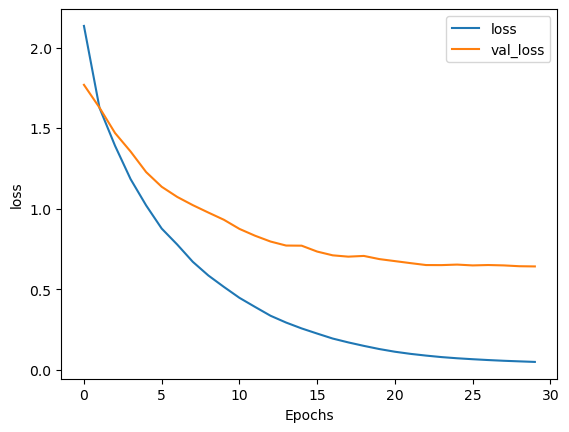

In [94]:
# Helper function

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plot_graphs(history, "loss")

In [101]:
model = Sequential([
tf.keras.layers.Conv1D(64, 3, activation='relu'),
tf.keras.layers.GlobalMaxPooling1D(),
Dense(10, activation='relu'),
Dense(number_classes, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(tf.convert_to_tensor(padded_inputs), y_encoded, epochs=15, validation_split=0.3)

Epoch 1/15
5/5 [==============================] - 1s 78ms/step - loss: 1.9262 - accuracy: 0.2593 - val_loss: 1.8057 - val_accuracy: 0.1724
Epoch 2/15
5/5 [==============================] - 0s 20ms/step - loss: 1.6478 - accuracy: 0.2741 - val_loss: 1.6941 - val_accuracy: 0.2759
Epoch 3/15
5/5 [==============================] - 0s 39ms/step - loss: 1.5068 - accuracy: 0.3778 - val_loss: 1.6007 - val_accuracy: 0.3793
Epoch 4/15
5/5 [==============================] - 0s 34ms/step - loss: 1.3877 - accuracy: 0.4741 - val_loss: 1.5015 - val_accuracy: 0.4310
Epoch 5/15
5/5 [==============================] - 0s 33ms/step - loss: 1.2600 - accuracy: 0.5185 - val_loss: 1.4150 - val_accuracy: 0.5000
Epoch 6/15
5/5 [==============================] - 0s 30ms/step - loss: 1.1433 - accuracy: 0.5852 - val_loss: 1.3247 - val_accuracy: 0.5345
Epoch 7/15
5/5 [==============================] - 0s 20ms/step - loss: 1.0682 - accuracy: 0.6222 - val_loss: 1.2898 - val_accuracy: 0.5172
Epoch 8/15
5/5 [===========

In [102]:
model.evaluate(padded_test_inputs, y=le.transform(y_test))

3/3 [==============================] - 0s 17ms/step - loss: 1.2400 - accuracy: 0.5952


[1.2400312423706055, 0.5952380895614624]

In [82]:


def model_to_optimize(num_filters, kernel_size):
    model = Sequential([
    tf.keras.layers.Conv1D(num_filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(number_classes, activation='softmax')])
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

params = {
    "num_filters":[32, 64, 128],
    "kernel_size":[3, 5, 7],
}

model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=model_to_optimize,
                            epochs=20,
                           batch_size=10,
                            verbose=False)

from sklearn.model_selection import GridSearchCV
search = GridSearchCV(estimator=model, param_grid=params,
                              cv=2, verbose=1)
search_result = search.fit(padded_inputs, y_encoded)

/tmp/ipykernel_4528/114759089.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=model_to_optimize,


Fitting 2 folds for each of 9 candidates, totalling 18 fits


In [89]:
search_result.best_params_

{'kernel_size': 3, 'num_filters': 64}

In [83]:
search_result.best_params_
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel_size,param_num_filters,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1.882793,0.454283,0.298693,0.015253,3,32,"{'kernel_size': 3, 'num_filters': 32}",0.824742,0.770833,0.797788,0.026954,5
1,1.641088,0.024222,0.244344,0.042319,3,64,"{'kernel_size': 3, 'num_filters': 64}",0.886598,0.854167,0.870382,0.016216,1
2,1.414505,0.022797,0.277051,0.042893,3,128,"{'kernel_size': 3, 'num_filters': 128}",0.855670,0.833333,0.844502,0.011168,3
3,1.372716,0.237321,0.282250,0.001934,5,32,"{'kernel_size': 5, 'num_filters': 32}",0.752577,0.802083,0.777330,0.024753,8
4,1.531836,0.135869,0.266720,0.014222,5,64,"{'kernel_size': 5, 'num_filters': 64}",0.762887,0.875000,0.818943,0.056057,4
5,1.619876,0.008948,0.271923,0.003191,5,128,"{'kernel_size': 5, 'num_filters': 128}",0.835052,0.875000,0.855026,0.019974,2
6,1.255499,0.045334,0.298526,0.054369,7,32,"{'kernel_size': 7, 'num_filters': 32}",0.597938,0.729167,0.663552,0.065614,9
7,1.654373,0.025872,0.193702,0.041367,7,64,"{'kernel_size': 7, 'num_filters': 64}",0.762887,0.822917,0.792902,0.030015,6
8,1.777422,0.034260,0.296066,0.010772,7,128,"{'kernel_size': 7, 'num_filters': 128}",0.804124,0.770833,0.787479,0.016645,7


In [ ]:
from sklearn import model_selection
import tensorflow as tf
from keras.layers import TextVectorization
from keras.layers import Embedding
from keras import layers

max_words = 30 # Max number of words in a sentence

raw_inputs = X_train_embedded
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    X_train_embedded,
    maxlen=max_words,
    padding="pre",
    truncating="pre",
    dtype="float32",
)

# Affichage des scores moyens par pli
print('---------------------------------------------------------------------')
print('Scores par pli')
for i in range(0, len(acc_per_fold)):
  print('---------------------------------------------------------------------')
  print(f'> Pli {i+1} - Loss: {loss_per_fold[i]:.2f}',
        f'- Accuracy: {acc_per_fold[i]:.2f}%')
print('---------------------------------------------------------------------')
print('Scores moyens pour tous les plis :')
print(f'> Accuracy: {np.mean(acc_per_fold):.2f}',
      f'(+- {np.std(acc_per_fold):.2f})')
print(f'> Loss: {np.mean(loss_per_fold):.2f}')
print('---------------------------------------------------------------------')

In [ ]:
accuracy_data = []
loss_data = []
for i, h in enumerate(histories):
  acc = h.history['acc']
  val_acc = h.history['val_acc']
  loss = h.history['loss']
  val_loss = h.history['val_loss']
  for j in range(len(acc)):
    accuracy_data.append([i+1, j+1, acc[j], 'Entraînement'])
    accuracy_data.append([i+1, j+1, val_acc[j], 'Validation'])
    loss_data.append([i+1, j+1, loss[j], 'Entraînement'])
    loss_data.append([i+1, j+1, val_loss[j], 'Validation'])

acc_df = pd.DataFrame(accuracy_data,
                      columns=['Pli', 'Epoch', 'Accuracy', 'Données'])
sns.relplot(data=acc_df, x='Epoch', y='Accuracy', hue='Pli', style='Données',
            kind='line')

loss_df = pd.DataFrame(loss_data, columns=['Pli', 'Epoch', 'Perte', 'Données'])
sns.relplot(data=loss_df, x='Epoch', y='Perte', hue='Pli', style='Données',
            kind='line')

In [ ]:
# Use party one to implement a CNN

In [ ]:
# Tes with matrix embedding based solely on my vocab or on the whole spacy vocab

TODO : Once data has been generated, apply vizualization techniques found in partie 1 to it !